In [ ]:

from fastai.vision.all import PixelShuffle_ICNR

## Style transfer

En este notebook recrearemos los resultados del artículo de [Gatys](https://arxiv.org/abs/1508.06576) de Style-Transfer.

Empezaremos con la aplicación más boba del mundo y poco a poco iremos modificándola para llegar a style transfer y producir esto:
![cont](style.png)

In [1]:
import random
import gc

import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor, ToPILImage

import fastai.vision.all as fv
from fastai.callback.hook import hook_outputs

from fastprogress.fastprogress import progress_bar

from Layers import num_params, Normalize

In [2]:
to_pil=ToPILImage()
to_tensor=ToTensor()

In [3]:
size = (384,256)

## Contenido

Primero haremos la aplicación más boba del mundo: A partir de ruido, crearemos la flor. Poco a poco iremos modificando el código para que al final lleguemos a transferencia de estilo.

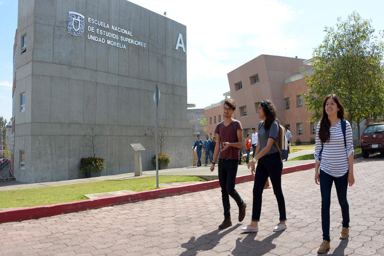

In [8]:
content_img = fv.PILImage.create("enes.jpeg").resize(size)
content_img

In [9]:
content_tensor = Normalize()(to_tensor(content_img)[None])

In [10]:
content_tensor.shape

torch.Size([1, 3, 256, 384])

Dos funcioncitas de ayuda: Una para desnormalizar y otra para ver:

In [11]:
def denorm(t):
    mean,sd = (torch.tensor(x) for x in fv.imagenet_stats)
    mean,sd = mean[:,None,None],sd[:,None,None]
    return mean + t*sd

def view(t):
    t = t.detach().cpu()
    if len(t.shape) == 4:
        t = t[0]
    return to_pil(denorm(t).clamp(0,1))
    #return to_pil(denorm(t))

In [12]:
content_tensor.shape

torch.Size([1, 3, 256, 384])

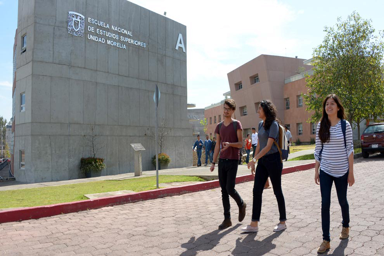

In [13]:
view(content_tensor)

In [14]:
content_tensor = content_tensor.to("cuda:1")

Vamos a crear ruido aleatorio, que iremos convirtiendo poco a poco a la imagen. **Notemos** que lo que estamos optimizando en sí es los pixeles de la imagen `noise`, por eso les ponemos gradientes.

In [15]:
noise = torch.randn_like(content_tensor,requires_grad=True)

In [ ]:
view(noise)

In [ ]:
optimizer = torch.optim.Adam([noise],lr=1e-1)

In [ ]:
pbar = progress_bar(range(100))
for epoch in pbar:
    optimizer.zero_grad()

    # Por ahora, pensemos que la pérdida será la distancia pixel a pixel a la original:
    loss = F.mse_loss(noise,content_tensor)
    pbar.comment = f"loss = {loss.item()}"
    
    loss.backward()
    optimizer.step()

In [ ]:
view(noise)

In [ ]:
view(content_tensor)

Bueno, pues obviamente no hay pierde: conseguimos error de 0 y la imagen es idéntica.

Vamos a hacerlo de nuevo, pero esta vez vamos a hacerlo de una manera ligeramente diferente: Ahora no vamos directamente a decirle que queremos que los pixeles en sí se parezcan. Más bien vamos a decirle que queremos que las activaciones de una red neuronal pre-entrenada (en este caso usaremos VGG... después explicaré por qué) se parezcan.

A esta pérdida se le llama **Feature Loss** o **Perceptual Loss**.

In [16]:
class PerceptualLoss(nn.Module):
    def __init__(self, model, layer_ids, weights=[1,3,8,12,20,10]):
        super().__init__()
        self.model = model
        self.important_layers = [self.model[i] for i in layer_ids]
        self.hooks = hook_outputs(self.important_layers, detach=False)
        self.weights = weights

    def extract_features(self, x, clone=False):
        self.model(x)
        features = list(self.hooks.stored)
        
        if clone:
            features = [f.clone() for f in features]
        
        return features
    
    def forward(self, x, content_image):
        x_features = self.extract_features(x)
        content_features = self.extract_features(content_image, clone=True)
        
        return sum([F.mse_loss(a, b)*w for a, b, w in zip(x_features, content_features, self.weights)])

    def __del__(self): 
        self.hooks.remove() # necesario para que deje de guardar las cosas

In [17]:
vgg = fv.vgg16_bn(pretrained=True)

/home/mraggi/anaconda3/envs/fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/mraggi/anaconda3/envs/fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [19]:
vgg = vgg.features

In [20]:
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [21]:
for p in vgg.parameters():
    p.requires_grad_(False)

In [22]:
good_blocks = [i-1 for i,m in enumerate(vgg) if type(m)==nn.MaxPool2d]

In [23]:
good_blocks #= [5,15,25,35,40]

[5, 12, 22, 32, 42]

In [24]:
perceptual_loss = PerceptualLoss(vgg,good_blocks).to("cuda:1")

In [25]:
#content_tensor.to("cuda:1")

In [26]:
noise = torch.randn_like(content_tensor,requires_grad=True)

In [27]:
noise

tensor([[[[ 0.5955, -0.4164,  0.1179,  ...,  0.3543,  0.5726, -1.1574],
          [-1.4917,  1.3131,  2.1013,  ...,  0.9789,  0.3731, -0.9031],
          [-1.4336, -1.0005, -0.2180,  ...,  0.5952, -0.0683,  1.5647],
          ...,
          [ 1.2894, -1.7548, -0.1498,  ..., -1.3323, -0.3487,  0.0655],
          [-0.3620, -0.7223,  0.4371,  ...,  0.3233,  0.0894,  0.7563],
          [ 1.4097, -0.0860,  1.4305,  ..., -0.3984,  0.2724,  1.1645]],

         [[-0.8707, -0.7029, -0.3899,  ..., -0.2277, -0.0896, -0.8412],
          [ 0.1063, -1.1360, -2.0488,  ...,  0.2903, -0.6097, -0.1096],
          [-0.4204,  1.0689,  0.2288,  ..., -1.8209,  0.9850,  0.5724],
          ...,
          [ 0.4066, -0.5384,  2.6781,  ...,  0.4854, -1.7707, -1.4124],
          [ 0.5717,  1.0003,  0.5917,  ...,  0.1242,  1.2284,  0.4451],
          [-2.2911, -1.3131, -0.6843,  ...,  0.5988,  0.1315,  1.2456]],

         [[-0.3354,  0.3889, -0.3155,  ...,  0.4267,  0.6991, -0.8044],
          [-0.0378, -1.6875,  

In [28]:
optimizer = torch.optim.Adam([noise],lr=1e-1)

In [29]:
pbar = progress_bar(range(2000))
for epoch in pbar:
    optimizer.zero_grad()

    # Por ahora, pensemos que la pérdida será la distancia pixel a pixel a la original:
    loss = perceptual_loss(noise,content_tensor)
    pbar.comment = f"loss = {loss.item():.3f}"
    
    loss.backward()
    optimizer.step()

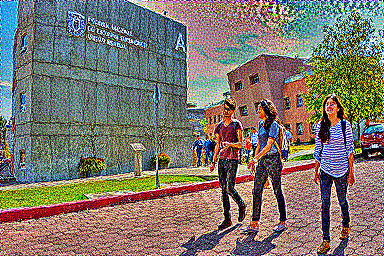

In [30]:
view(noise)

# Agregando estilo!

Primero, empecemos con la imagen ya "perfecta".

In [31]:
pbar = progress_bar(range(1000))
for epoch in pbar:
    optimizer.zero_grad()

    # Por ahora, pensemos que la pérdida será la distancia pixel a pixel a la original:
    loss = F.mse_loss(noise,content_tensor)
    pbar.comment = f"loss = {loss.item()}"
    
    loss.backward()
    optimizer.step()

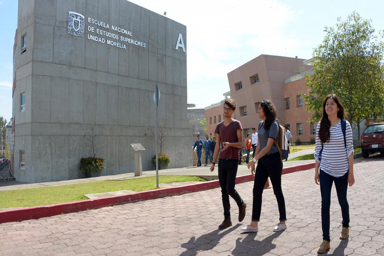

In [32]:
view(noise)

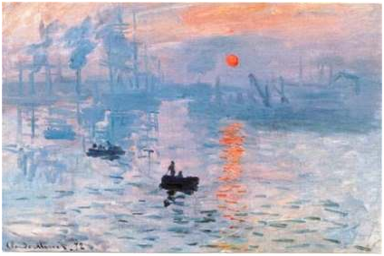

In [43]:
style = fv.PILImage.create("starrynight.jpg.").resize(size)
style

In [44]:
style_tensor = Normalize()(to_tensor(style)).to("cuda:1")

In [45]:
style_tensor

tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2318,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2147, 2.0605,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2318,  ..., 2.0777, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2147, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.3936, 2.2360,  ..., 2.4111, 2.4286, 2.4286],
          [2.4286, 2.3060, 1.5707,  ..., 2.3585, 2.4111, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.1660, 2.4111, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.3585, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.5877, 2.2391,  ..., 2.6051, 2.6400, 2.6400],
          [2.6400, 2.4134, 1.0888,  ..., 2

La idea genial de Gatys y ellos fue que podían entender el "estilo" como la *covarianza* entre los diferentes canales de las activaciones. 

Para calcular la correlación, simplemente hay que tomar el producto de matrices así (llamada la matriz de Gram):

In [46]:
def gram_matrix(x):
    bs,c,h,w = x.shape
    x = x.view(bs, c, h*w)
    return (x @ x.transpose(1,2))/(c*h*w)

In [47]:
class StyleAndContentLoss(nn.Module):
    def __init__(self, model, layer_ids, content_weights=[1,3,8,12,20,10], 
                 style_weights=[20,25,15,10,4], style_mult=8e3):
        super().__init__()
        self.model = model
        self.important_layers = [self.model[i] for i in layer_ids]
        self.hooks = hook_outputs(self.important_layers, detach=False)
        self.content_weights = content_weights
        self.style_weights = style_weights
        self.style_mult = style_mult

    def extract_features(self, x, clone=False):
        self.model(x)
        features = list(self.hooks.stored)
        
        if clone:
            features = [f.clone() for f in features]
        
        return features
    
    def content_loss(self, A, B):
        return sum([F.l1_loss(a, b)*w for a, b, w in zip(A, B, self.content_weights)])
    
    def style_loss(self, A, B):
        return sum([F.l1_loss(gram_matrix(a), gram_matrix(b))*w for a, b, w in zip(A, B, self.style_weights)])
    
    def forward(self, x, content_image, style_image):
        x_features = self.extract_features(x)
        content_features = self.extract_features(content_image, clone=True)
        style_features = self.extract_features(style_image, clone=True)
        
        self.CL = self.content_loss(x_features, content_features)
        self.SL =  self.style_mult*self.style_loss(x_features, style_features)

        return self.CL + self.SL
    
    def __del__(self): 
        self.hooks.remove() # necesario para que deje de guardar las cosas

In [48]:
def style_content_loss(**kwargs):
    vgg = fv.vgg16_bn(pretrained=True)
    vgg.eval()
    vgg = vgg.features
    for p in vgg.parameters(): p.requires_grad_(False)
    good_blocks = [i for i,x in enumerate(vgg.children()) if type(x) == nn.MaxPool2d]
    
    return StyleAndContentLoss(vgg, layer_ids=good_blocks, **kwargs)

In [49]:
content_and_style_loss = style_content_loss().to("cuda:1")

In [50]:
optimizer = torch.optim.Adam([noise],lr=1e-1)

In [51]:
pbar = progress_bar(range(2000))
for epoch in pbar:
    optimizer.zero_grad()

    loss = content_and_style_loss(noise,content_tensor,style_tensor)
    pbar.comment = f"| content_loss = {content_and_style_loss.CL:.2f} | style_loss = {content_and_style_loss.SL:.2f} | total loss = {loss.item():.2f}"
    
    loss.backward()
    optimizer.step()

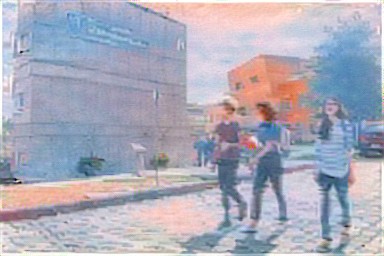

In [52]:
view(noise)